In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
%matplotlib inline

In [2]:
# loading the dataset
diabetes_df = pd.read_csv('../datasets/diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# checking shape
diabetes_df.shape

(768, 9)

In [4]:
# checking the datatypes
diabetes_df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
# checking for null values
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# since there are no null values no need for data imputation
# checking the summary stats for data 
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# separating feature matrix and label vector
X = diabetes_df.drop(columns='Outcome').values
y = diabetes_df['Outcome'].values

In [8]:
# writing train test split function
def train_test_split(
    X: np.ndarray, y: np.ndarray, test_size: float = 0.3, random_seed: int = 42
):
    """Separates the dataset into train and test sets
    Args:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Label Vector
        test_size (float, optional):
          Proportion of dataset to include in the test split
          Defaults to 0.3.
        random_seed (int, optional):
          Seed for reproduceability
          Defaults to 41.
    Returns:
      X_train, X_test, y_train, y_test : np.ndarray
        Training and testing splits of features and target.
    """
    np.random.seed(random_seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [9]:
# separate the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"Shape of X train: {X_train.shape}")
print(f"Shape of y train: {y_train.shape}")
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X train: (538, 8)
Shape of y train: (538,)
Shape of X test: (230, 8)
Shape of y test: (230,)


In [10]:
# function for euclidean distance
def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    """Calculates the distance between two points
    Args:
        point1 (np.ndarray): The first point as numpy array
        point2 (np.ndarray): The second point as numpy array
    Returns:
        float: The Euclidean distance between two points
    Raises:
        ValueError: If the dimensions of two point are different
    """
    if point1.shape != point2.shape:
        raise ValueError(
            "Dimensions of two points must be same to calculate euclidean distance"
        )
    distance = np.sqrt(np.sum((point1 - point2) ** 2))
    return distance

In [11]:
# Test case for function
try:
  point1 = np.array([5, 5])
  point2 = np.array([2, 1])
  result = euclidean_distance(point1, point2)
  expected_result = 5.0
  assert np.isclose(result, expected_result), f"Expected {expected_result}, got {result}"
  print("Test Passed Successfully")
except ValueError as ve:
  print(f"ValueError: {ve}")
except AssertionError as ae:
  print(f"AssertionError: {ae}")
except Exception as e:
  print(f"Error occured: {e}")

Test Passed Successfully


In [12]:
# function for prediction of single querypoint
def knn_single_predict(
    query_point: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, k: int = 3
) -> int:
    """KNN algorithm to find predicted label for single query

    Args:
        query_point (np.ndarray): Query point for which prediction is to be made
        X_train (np.ndarray): The training feature matrix
        y_train (np.ndarray): The training label vector
        k (int, optional): Number fo nearest neighbor to consider Defaults to 3.

    Returns:
        int: Predicted class label for the query point.
    """
    distances = [euclidean_distance(x, query_point) for x in X_train]
    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:k]
    nearest_labels = y_train[nearest_indices]
    predicted = np.bincount(nearest_labels).argmax()
    return predicted

In [13]:
# prediction for whole dataset
def knn_predict(
    X_test: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, k: int = 3
) -> np.ndarray:
    """Return list of predicted class label for every point in test data using KNN algorithm

    Args:
        X_test (np.ndarray): Testing Feature Matix
        X_train (np.ndarray): Training Feature Matrix
        y_train (np.ndarray): Training label vector
        k (int, optional): Number of nearest label to consider Defaults to 3.

    Returns:
        np.ndarray: Numpy Array of predicted class labels for test data
    """
    predictions = [knn_single_predict(x, X_train, y_train, k) for x in X_test]
    return np.array(predictions)

In [14]:
# function to calculate accuray 
def compute_accuracy(y_true: np.ndarray, y_test: np.ndarray) -> float:
  """Calculates the accuracy of predictions done through KNN

  Args:
      y_true (np.ndarray): The true labels
      y_test (np.ndarray): The predicted labels

  Returns:
      float: Accuracy of predictions in percentage
  """  
  total_correct = np.sum(y_true == y_test)
  total = len(y_true)
  accuracy = total_correct / total * 100
  return accuracy

In [15]:
# Test case for KNN 
try:
  X_test_sample = X_test[:5] 
  y_test_sample = y_test[:5] 
  predictions = knn_predict(X_test_sample, X_train, y_train, k=3)
  accuracy = compute_accuracy(y_test_sample, predictions)
  print("Predictions:", predictions)
  print("Actual labels:", y_test_sample)
  print("Accuray of algorithm", round(accuracy, 2))
  assert predictions.shape == y_test_sample.shape, "The shape of predictions does not match the shape of the actual labels."
  print("Test case passed successfully!")
except AssertionError as ae:
  print(f"AssertionError: {ae}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Predictions: [0 1 0 1 1]
Actual labels: [0 0 0 0 0]
Accuray of algorithm 40.0
Test case passed successfully!


In [16]:
from typing import Callable

def knn_prediction_with_timing(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    knn_predict: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray],
    compute_accuracy: Callable[[np.ndarray, np.ndarray], float],
    k: int = 3, 
) -> tuple[float, float]:
    """
    Function to perform KNN predictions on given data and measure prediction time and accuracy.

    Parameters:
    - X_train_scaled (np.ndarray): Training feature matrix.
    - X_test_scaled (np.ndarray): Test feature matrix.
    - y_train (np.ndarray): Training labels.
    - y_test (np.ndarray): Test labels.
    - knn_predict (Callable): Function that takes the test features, training features,
      and training labels, and returns predicted labels.
    - compute_accuracy (Callable): Function that takes the true labels and predicted labels, and returns the accuracy.
    - k (int): Number of neighbors to consider (defaults to 3)

    Returns:
    - accuracy, prediction_time: 
        Accuracy for the value of k and the prediction time.

    Raises:
    - Exception: If any error occurs during the prediction or accuracy computation process.
    """
    try:
        prediction_time = timeit(
            lambda: knn_predict(X_test, X_train, y_train, k), number=1
        )
        predictions = knn_predict(X_test, X_train, y_train, k)
        accuracy = compute_accuracy(y_test, predictions)

        return accuracy, prediction_time
    except Exception as e:
        print(f"Exception occurred: {e}")

In [17]:
# KNN for acutual data
try:
    accuracy, prediction_time = knn_prediction_with_timing(
        X_train, X_test, y_train, y_test, knn_predict, compute_accuracy
    )

    print(f"Accuracy of KNN algorithm on actual data: {accuracy:.2f} %")
    print(f"Time taken for prediction on actual data: {prediction_time:.2f} seconds")
except Exception as e:
    print(f"Exception: {e}")


Accuracy of KNN algorithm on actual data: 67.39 %
Time taken for prediction on actual data: 1.00 seconds


In [18]:
# Problem 2 : Experimentation
# function to scale the feature matrix using standarization
def scale_data(
    X_train: np.ndarray, X_test: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Scales the training and testing datasets using the statistics (mean and standard deviation)
    computed from the training data.

    Parameters:
    X_train (np.ndarray): Training feature matrix of shape (n_samples_train, n_features).
    X_test (np.ndarray): Testing feature matrix of shape (n_samples_test, n_features).

    Returns:
    tuple[np.ndarray, np.ndarray]: Tuple containing the scaled training and testing feature matrices.
    """
    means = np.mean(X_train, axis=0)
    stds = np.std(X_train, axis=0)

    X_train_scaled = (X_train - means) / np.where(stds != 0, stds, 1)
    X_test_scaled = (X_test - means) / np.where(stds != 0, stds, 1)

    return X_train_scaled, X_test_scaled

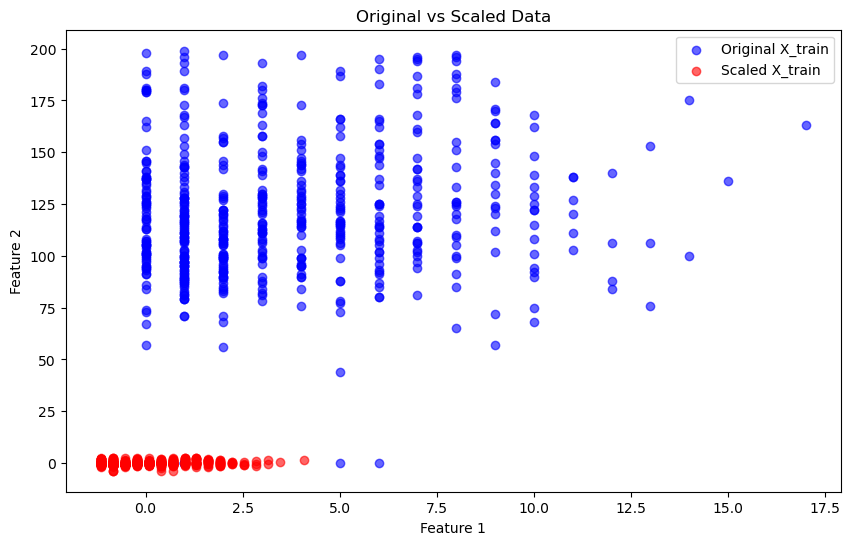

In [19]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue', label='Original X_train', alpha=0.6)

plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color='red', label='Scaled X_train', alpha=0.6)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original vs Scaled Data')

plt.legend()
plt.show()

In [20]:
# KNN for scaled data
try:
    accuracy, prediction_time = knn_prediction_with_timing(
        X_train_scaled, X_test_scaled, y_train, y_test, knn_predict, compute_accuracy
    )

    print(f"Accuracy of KNN algorithm on scaled data: {accuracy:.2f} %")
    print(f"Time taken for prediction on scaled data: {prediction_time:.2f} seconds")
except Exception as e:
    print(f"Exception: {e}")

Accuracy of KNN algorithm on scaled data: 70.87 %
Time taken for prediction on scaled data: 0.96 seconds


### Comparative Analysis

- For the problem 1, where data was not scaled the accuracy was observed to be `67.39 %`.
- After the data was scaled using the normalization/standarization techique, the accuracy of KNN increased and got to `70.87 %` while a difference in execution time was also observed as compared knn on the actual data. 

**Reasons for changes in accuracy**




In [21]:
# knn algorithm for different values of k
def experiment_knn_k_values(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    k_values: list[int],
) -> tuple[dict, dict]:
    """Runs KNN algorithm for different values of k and plot the accuracies

    Args:
        X_train (np.ndarray): The training feature matrix
        y_train (np.ndarray): The training label vector
        X_test (np.ndarray): The testing feature matrix
        y_test (np.ndarray): The testing label vector
        k_values (list[int]): List of k values to experiment with

    Returns:
        accuracies, prediction_times:
            Two dict with k values as key and their corresponding accuracy and prediction_time as values
    """
    accuracies = {}
    prediction_times = {} 
    for k in k_values:
        accuracy, time_taken = knn_prediction_with_timing(
            X_train, X_test, y_train, y_test, knn_predict, compute_accuracy, k
        )
        accuracies[k] = accuracy
        prediction_times[k] = time_taken
        print(f"For k = {k}, Accuracy = {accuracy:.2f}, Time Taken = {time_taken:.2f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 
    axes[0].plot(k_values, list(accuracies.values()), marker="o", color="blue")
    axes[0].set_title("Accuracy of KNN with Different Values of k")
    axes[0].set_xlabel("k (Number of Neighbors)")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].grid(True)

    axes[1].plot(k_values, list(prediction_times.values()), marker="o", color="red")
    axes[1].set_title("Prediction Time for Different Values of k")
    axes[1].set_xlabel("k (Number of Neighbors)")
    axes[1].set_ylabel("Time (seconds)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    return accuracies, prediction_times

For k = 1, Accuracy = 68.70, Time Taken = 0.86
For k = 2, Accuracy = 72.61, Time Taken = 1.05
For k = 3, Accuracy = 67.39, Time Taken = 0.95
For k = 4, Accuracy = 72.17, Time Taken = 0.95
For k = 5, Accuracy = 68.70, Time Taken = 0.93
For k = 6, Accuracy = 70.00, Time Taken = 1.10
For k = 7, Accuracy = 69.13, Time Taken = 0.82
For k = 8, Accuracy = 71.30, Time Taken = 0.89
For k = 9, Accuracy = 70.00, Time Taken = 0.82
For k = 10, Accuracy = 71.74, Time Taken = 0.82
For k = 11, Accuracy = 73.04, Time Taken = 0.93
For k = 12, Accuracy = 73.91, Time Taken = 0.84
For k = 13, Accuracy = 74.35, Time Taken = 1.04
For k = 14, Accuracy = 72.61, Time Taken = 0.91
For k = 15, Accuracy = 73.91, Time Taken = 0.91


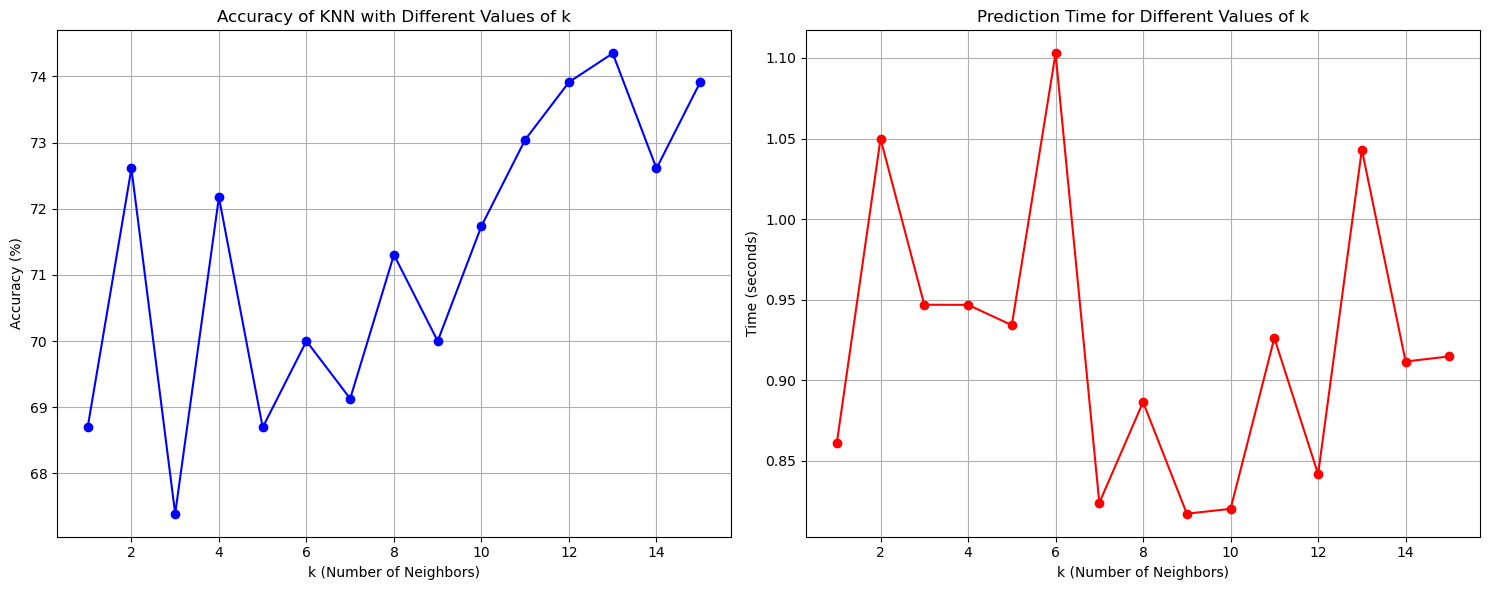

Experiment completed. Check the plot for the accuracy trend.


In [22]:
# testing with k values from 1 to 15
k_values = range(1, 16)
# for actual data
try:
    accuracies, prediction_time = experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values)
    print("Experiment completed. Check the plot for the accuracy trend.")
except Exception as e:
    print(f"An unexpected error occurred during the experiment: {e}")

For k = 1, Accuracy = 63.48, Time Taken = 0.90
For k = 2, Accuracy = 66.09, Time Taken = 0.89
For k = 3, Accuracy = 70.87, Time Taken = 0.96
For k = 4, Accuracy = 68.70, Time Taken = 0.85
For k = 5, Accuracy = 70.00, Time Taken = 1.00
For k = 6, Accuracy = 69.13, Time Taken = 0.99
For k = 7, Accuracy = 69.57, Time Taken = 0.89
For k = 8, Accuracy = 68.70, Time Taken = 0.89
For k = 9, Accuracy = 69.57, Time Taken = 0.89
For k = 10, Accuracy = 69.57, Time Taken = 0.93
For k = 11, Accuracy = 70.87, Time Taken = 1.87
For k = 12, Accuracy = 72.17, Time Taken = 2.06
For k = 13, Accuracy = 71.30, Time Taken = 2.14
For k = 14, Accuracy = 71.30, Time Taken = 2.40
For k = 15, Accuracy = 73.91, Time Taken = 3.56


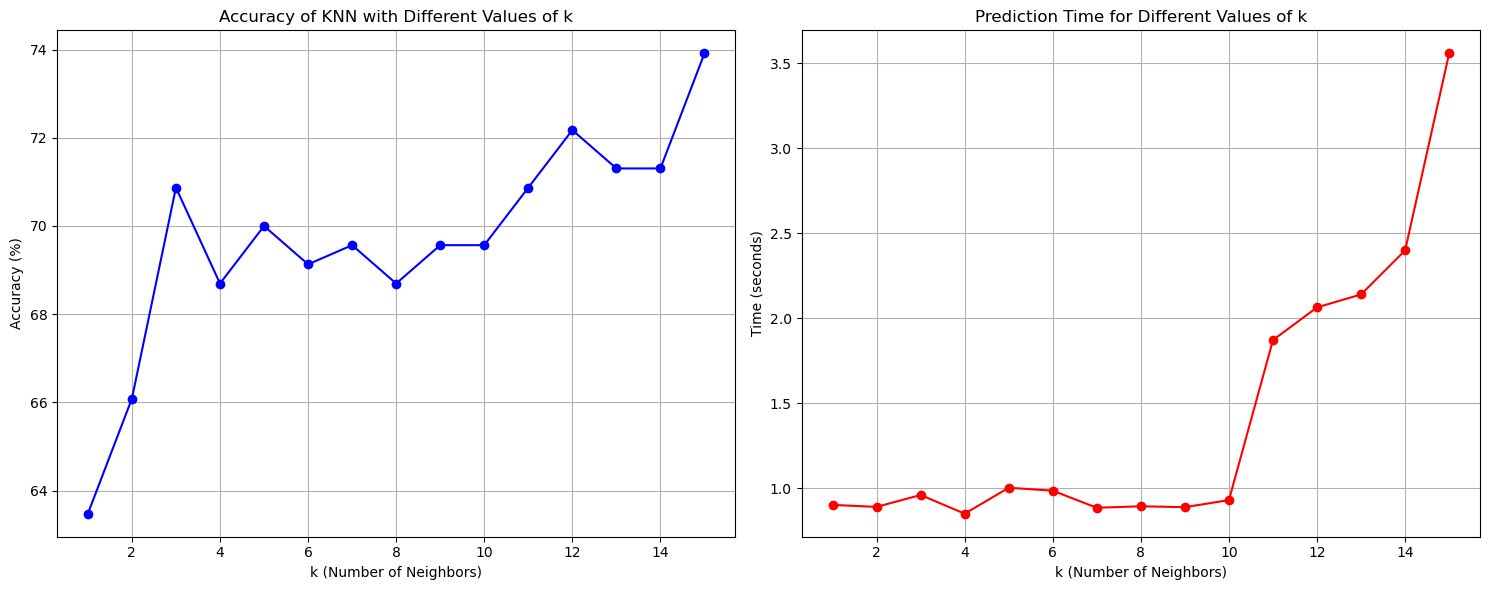

Experiment completed. Check the plot for the accuracy trend.


In [23]:
# accuracies for scaled data
try:
    accuracies = experiment_knn_k_values(X_train_scaled, y_train, X_test_scaled, y_test, k_values)
    print("Experiment completed. Check the plot for the accuracy trend.")
except Exception as e:
    print(f"An unexpected error occurred during the experiment: {e}")

**Disscussion**

- Discuss how the choice of k affects the accuracy and computational cost.
- Identify the optimal k based on your analysis.


The choice of k affects both accuracy and computational cost. A small k (like 1) makes the model very sensitive to noise and can lead to overfitting, while a large k  smooths out noise but may cause underfitting. Accuracy usually improves as k increases up to a point, then stabilizes or drops. 
Computational cost slightly increases with larger k as more neighbors need to be considered during prediction which can be clearly observed for the data above.

From the analysis, the optimal k is where accuracy stabilizes without overfitting or underfitting. For this dataset, the optimal k was found to be between 15, balancing accuracy and performance.

After scaling the data the plot is observed to be more smoother that proves knn performs better in scaled data as the distance between the points is decreased

### Problem - 4 - Additional Questions: 

- Discuss the challenges of using KNN for large datasets and high-dimensional data.
- Suggest strategies to improve the efficiency of KNN (e.g., approximate nearest neighbors, dimensionality
reduction).

k-Nearest Neighbors (kNN) can be challenging to use with large datasets and high-dimensional data because it calculates distances for every test point, which takes a lot of time and memory. In high dimensions, the distances between points become less meaningful, making it harder to find the nearest neighbors accurately. It also struggles with irrelevant features or noise, which can confuse the algorithm and lower accuracy.

To improve kNN, we can use methods like Approximate Nearest Neighbors (ANN), which make the search faster by estimating neighbors instead of checking every single point. Reducing the number of features with techniques like PCA or selecting only the important ones helps avoid the "curse of dimensionality." Scaling the data ensures all features contribute equally, and weighted kNN can give more importance to closer points. Tools like parallel processing or GPU-based libraries can speed up computations, and finding the best k value through experiments can balance accuracy and performance.